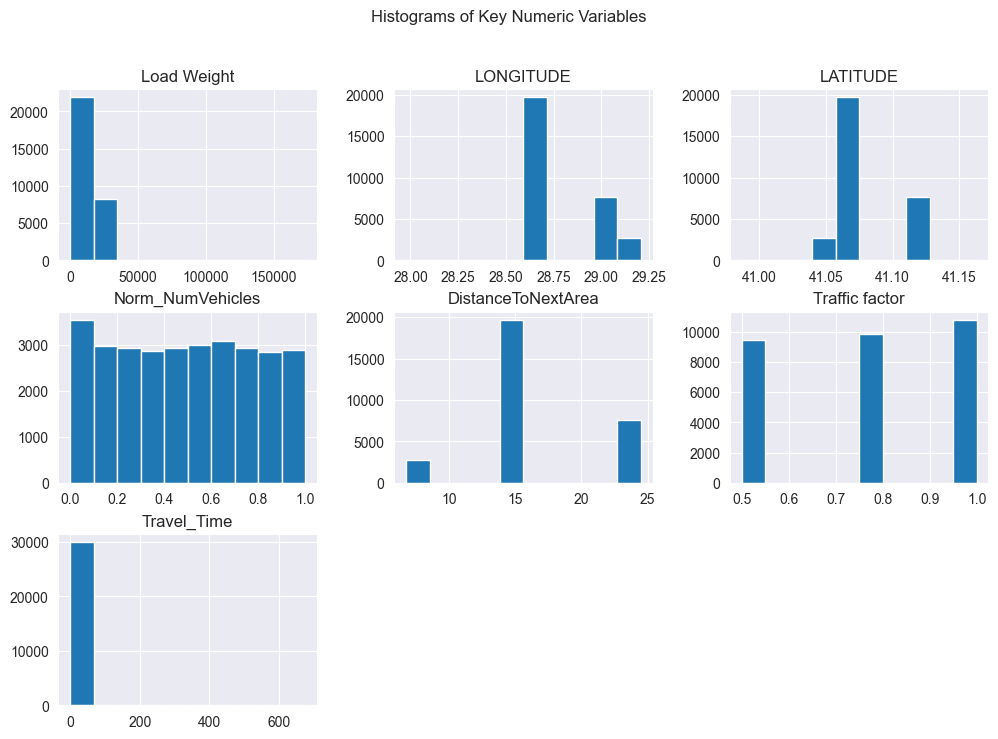

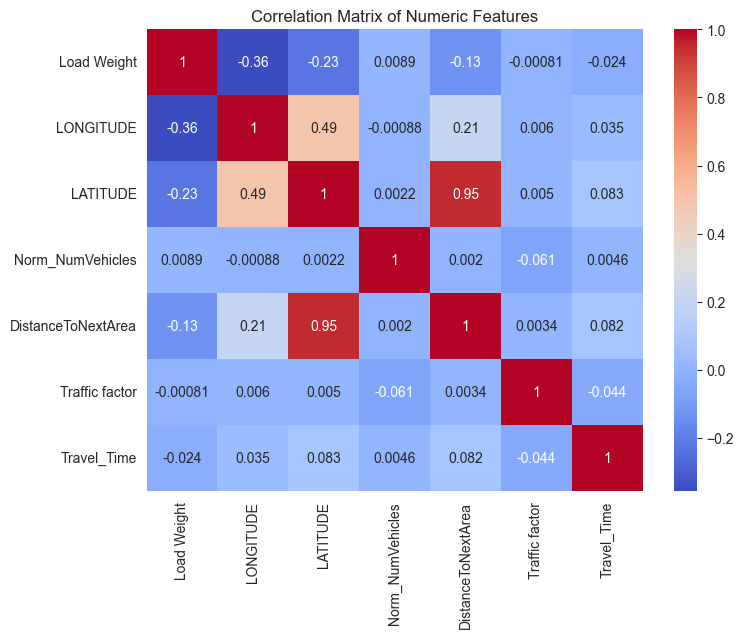

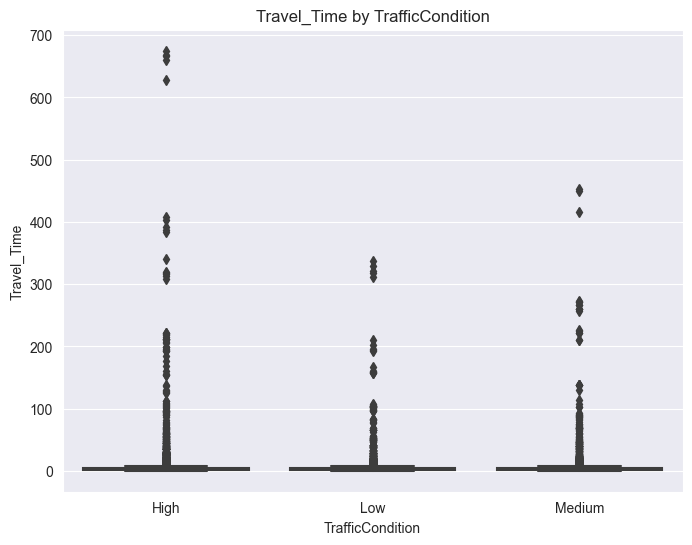

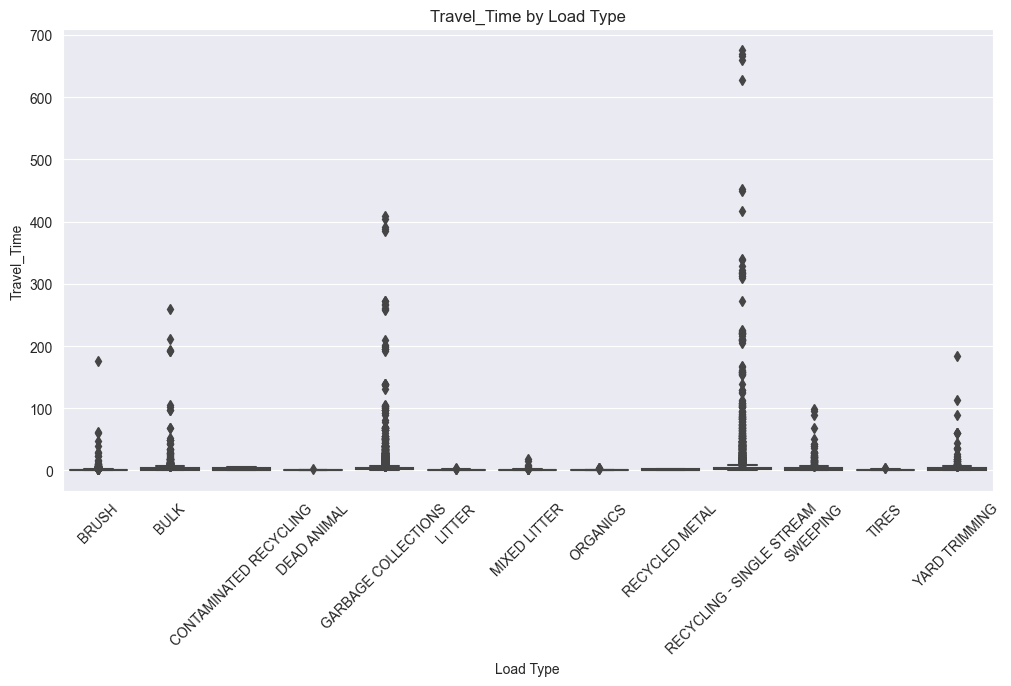

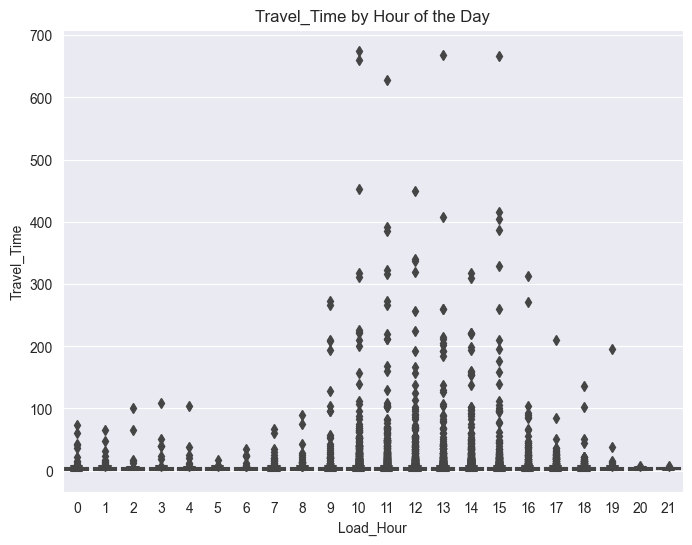


Initial Model Comparison:
                   Model       MAE       RMSE        R²
6           RandomForest  0.747188   2.088243  0.982240
5           DecisionTree  0.939303   3.266827  0.956537
11              Stacking  0.997826   5.647718  0.870097
7       GradientBoosting  1.139005   7.137404  0.792531
9           MLPRegressor  2.015437  14.296801  0.167566
4   PolynomialRegression  2.559160  15.672193 -0.000303
8                    SVR  2.468326  15.685608 -0.002016
1                  Ridge  2.636813  15.708492 -0.004942
0       LinearRegression  2.637287  15.708642 -0.004961
10         BayesianRidge  2.636441  15.709195 -0.005032
3             ElasticNet  2.682857  15.734039 -0.008214
2                  Lasso  2.736112  15.743305 -0.009401

Best RandomForest Params: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Tuned RandomForest Results - MAE: 0.7700447736715755 RMSE: 2.2555586915566614 R²: 0.9792

In [4]:
# ----------------------------
# Importing Required Libraries
# ----------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Linear and related models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge

# Tree-based and ensemble models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

# SVM and Neural Net
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Attempt to import XGBoost, LightGBM, CatBoost
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False

try:
    from lightgbm import LGBMRegressor
    lgbm_available = True
except ImportError:
    lgbm_available = False

try:
    from catboost import CatBoostRegressor
    cat_available = True
except ImportError:
    cat_available = False

# Suppress warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# ----------------------------
# Step 1: Load the Dataset
# ----------------------------
df = pd.read_csv('final_waste_collection_data.csv')

# ----------------------------
# Step 2: Convert Date/Time Columns
# ----------------------------
df['Report Date'] = pd.to_datetime(df['Report Date'], format='%m/%d/%Y', errors='coerce')
df['Load Time'] = pd.to_datetime(df['Load Time'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# ----------------------------
# Step 3: Extract Time-Based Features
# ----------------------------
df['Load_Hour'] = df['Load Time'].dt.hour
df['Load_Day'] = df['Load Time'].dt.day
df['Load_Month'] = df['Load Time'].dt.month
df['Load_Weekday'] = df['Load Time'].dt.weekday

# ----------------------------
# Step 4: Parse Weather Conditions
# ----------------------------
all_conditions = set()
for cond in df['conditions'].dropna():
    conditions_list = [c.strip() for c in cond.split(',')]
    for c in conditions_list:
        all_conditions.add(c)
all_conditions = list(all_conditions)

for c in all_conditions:
    condition_col = f'weather_{c.replace(" ", "_").lower()}'
    df[condition_col] = df['conditions'].apply(
        lambda x: 1 if (isinstance(x, str) and c in [e.strip() for e in x.split(',')]) else 0
    )

# Convert categorical columns
df['TrafficCondition'] = df['TrafficCondition'].astype('category')
df['Load Type'] = df['Load Type'].astype('category')
df['Route Type'] = df['Route Type'].astype('category')
df['Dropoff Site'] = df['Dropoff Site'].astype('category')

# Ensure numeric columns are correct
numeric_cols = [
    'Load Weight', 'LONGITUDE', 'LATITUDE', 'Norm_NumVehicles',
    'DistanceToNextArea', 'Traffic factor', 'Travel_Time'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop the original conditions column as it's no longer needed
df.drop(columns=['conditions'], inplace=True)

# ----------------------------
# Step 5: Handle Missing Values
# ----------------------------
numeric_impute_cols = ['Load Weight', 'DistanceToNextArea', 'Travel_Time']
for col in numeric_impute_cols:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

df = df.dropna(subset=['LONGITUDE', 'LATITUDE'])

# ----------------------------
# Step 6: Exploratory Data Analysis (EDA)
# ----------------------------
# Histograms of numeric variables
df[numeric_cols].hist(figsize=(12, 8))
plt.suptitle("Histograms of Key Numeric Variables")
plt.show()

# Correlation matrix
corr = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Boxplots for categorical variables against Travel_Time
plt.figure(figsize=(8, 6))
sns.boxplot(x='TrafficCondition', y='Travel_Time', data=df)
plt.title("Travel_Time by TrafficCondition")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Load Type', y='Travel_Time', data=df)
plt.title("Travel_Time by Load Type")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Load_Hour', y='Travel_Time', data=df)
plt.title("Travel_Time by Hour of the Day")
plt.show()

# ----------------------------
# Step 7: Additional Feature Engineering
# ----------------------------
df['DayOfWeek'] = df['Load Time'].dt.weekday
df['Month'] = df['Load Time'].dt.month

def bin_load_hour(hour):
    if hour < 6:
        return 'Night'
    elif 6 <= hour < 10:
        return 'Early_Morning'
    elif 10 <= hour < 14:
        return 'Late_Morning'
    elif 14 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Late_Night'

df['Load_Hour_Bin'] = df['Load_Hour'].apply(bin_load_hour)
df['Rain_HighTraffic'] = np.where((df['weather_rain'] == 1) & (df['TrafficCondition'] == 'High'), 1, 0)

# Log transform the target
df['Log_Travel_Time'] = np.log1p(df['Travel_Time'])

# Example interaction feature
df['Distance_Vehicles_Interaction'] = df['DistanceToNextArea'] * df['Norm_NumVehicles']

# ----------------------------
# Step 8: Define Features and Target
# ----------------------------
target = 'Log_Travel_Time'
numeric_features = [
    'Load Weight', 'Norm_NumVehicles', 'DistanceToNextArea', 'Traffic factor',
    'weather_clear', 'weather_overcast', 'weather_rain', 'weather_snow',
    'weather_partially_cloudy', 'Rain_HighTraffic', 'LONGITUDE', 'LATITUDE',
    'Distance_Vehicles_Interaction'
]

categorical_features = [
    'Load Type', 'Dropoff Site', 'Route Type', 'TrafficCondition', 'Load_Hour_Bin', 'DayOfWeek', 'Month'
]

X = df[numeric_features + categorical_features]
y = df[target]

# ----------------------------
# Step 9: Train-Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------
# Step 10: Preprocessing
# ----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
    ]
)

# ----------------------------
# Step 11: Define Models
# ----------------------------
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1),

    "PolynomialRegression": Pipeline([
        ('preprocessor', preprocessor),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('regressor', Ridge(alpha=1.0))
    ]),

    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf', C=1.0),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(50,50), max_iter=500, random_state=42),
    "BayesianRidge": BayesianRidge()
}

if xgb_available:
    models["XGBoost"] = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)

if lgbm_available:
    models["LightGBM"] = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)

if cat_available:
    models["CatBoost"] = CatBoostRegressor(iterations=100, verbose=0, random_state=42)

stacking_estimators = [
    ('ridge', Ridge(alpha=1.0)),
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
]
models["Stacking"] = StackingRegressor(estimators=stacking_estimators, final_estimator=Ridge(alpha=1.0))

# ----------------------------
# Step 12: Initial Model Evaluation
# ----------------------------
results = []
for model_name, model in models.items():
    if model_name == "PolynomialRegression":
        pipeline = model
    else:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Inverse transform the predictions
    y_pred_orig = np.expm1(y_pred)
    y_test_orig = np.expm1(y_test)

    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    rmse = mean_squared_error(y_test_orig, y_pred_orig, squared=False)
    r2 = r2_score(y_test_orig, y_pred_orig)

    results.append({'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R²': r2})

results_df = pd.DataFrame(results).sort_values('RMSE')
print("\nInitial Model Comparison:")
print(results_df)

# Identify top-performing models (example: RandomForest, GradientBoosting, Stacking)
top_models = ['RandomForest', 'GradientBoosting', 'Stacking']

# ----------------------------
# Step 13: Hyperparameter Tuning for Top Model (RandomForest Example)
# ----------------------------
rf_param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

best_rf = rf_grid_search.best_estimator_
print("\nBest RandomForest Params:", rf_grid_search.best_params_)

y_pred_rf = best_rf.predict(X_test)
y_pred_rf_orig = np.expm1(y_pred_rf)
y_test_orig = np.expm1(y_test)
rf_mae = mean_absolute_error(y_test_orig, y_pred_rf_orig)
rf_rmse = mean_squared_error(y_test_orig, y_pred_rf_orig, squared=False)
rf_r2 = r2_score(y_test_orig, y_pred_rf_orig)
print("Tuned RandomForest Results - MAE:", rf_mae, "RMSE:", rf_rmse, "R²:", rf_r2)

# Optional: You can similarly tune GradientBoosting or Stacking models by defining parameter grids and running GridSearchCV.

# ----------------------------
# Step 14: Multiple Trials & Cross-Validation
# ----------------------------
# Check stability with different random seeds and cross-validation for the tuned RandomForest model
cv_scores = []
for seed in [42, 100, 2021]:
    rf_pipeline_random = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=rf_grid_search.best_params_['regressor__n_estimators'],
            max_depth=rf_grid_search.best_params_['regressor__max_depth'],
            min_samples_split=rf_grid_search.best_params_['regressor__min_samples_split'],
            min_samples_leaf=rf_grid_search.best_params_['regressor__min_samples_leaf'],
            random_state=seed
        ))
    ])

    scores = cross_val_score(rf_pipeline_random, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    cv_scores.append(-scores.mean())

print("\nCross-Validation RMSE for tuned RandomForest with different seeds:", cv_scores)
print("Mean CV RMSE:", np.mean(cv_scores))

# At this point, consider adding more feature engineering, trying more models, or further tuning.